## An example of model inference and visualization
#### Prepare the input data and model

We generate the cropped images from COCO2017 valiadation set by using the GT human bounding boxes. And we load the model with the COCO pre-trained weights. The models also can be directly loaded from torch hub ([CoLab demo](https://colab.research.google.com/drive/1v2LY_rAZXqexPjiePmqgma4aw-qmRek6?usp=sharing)).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os.path as osp
import sys
import os
import torch

from visualize import update_config, add_path

lib_path = osp.join('lib')
add_path(lib_path)

import dataset as dataset
from config import cfg
import models
import os
import torchvision.transforms as T

os.environ['CUDA_VISIBLE_DEVICES'] ='0'
file_name = 'experiments/coco/transpose_r/TP_R_256x192_d256_h1024_enc4_mh8.yaml' # choose a yaml file
f = open(file_name, 'r')
update_config(cfg, file_name)

model_name = 'T-H-A4'
assert model_name in ['T-R', 'T-H','T-H-L','T-R-A4', 'T-H-A6', 'T-H-A5', 'T-H-A4' ,'T-R-A4-DirectAttention']

normalize = T.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )

dataset = eval('dataset.'+cfg.DATASET.DATASET)(
        cfg, cfg.DATASET.ROOT, cfg.DATASET.TEST_SET, False,
        T.Compose([
            T.ToTensor(),
            normalize,
        ])
    )


device = torch.device('cuda')
model = eval('models.'+cfg.MODEL.NAME+'.get_pose_net')(
    cfg, is_train=True
)

if cfg.TEST.MODEL_FILE:
    print('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=True)
else:
    raise ValueError("please choose one ckpt in cfg.TEST.MODEL_FILE")

model.to(device)
print("model params:{:.3f}M".format(sum([p.numel() for p in model.parameters()])/1000**2))

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
:: conv1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.running_mean is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.running_var is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: bn1.bias is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.conv1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.running_mean is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.running_var is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn1.bias is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.conv2.weight is loaded from models/pytorch/imagenet/resnet50-19c8e357.pth
:: layer1.0.bn

#### Obtain the predictions

We feed an input sample to the model, get the predicted keypoint heatmaps and further obtain the positions of keypoints. 

In [2]:
import numpy as np 
from lib.core.inference import get_final_preds
from lib.utils import transforms, vis
import cv2


with torch.no_grad():
    model.eval()
    tmp = []
    tmp2 = []
    img = dataset[0][0]

    inputs = torch.cat([img.to(device)]).unsqueeze(0)
    outputs = model(inputs)
    if isinstance(outputs, list):
        output = outputs[-1]
    else:
        output = outputs

    if cfg.TEST.FLIP_TEST: 
        input_flipped = np.flip(inputs.cpu().numpy(), 3).copy()
        input_flipped = torch.from_numpy(input_flipped).cuda()
        outputs_flipped = model(input_flipped)

        if isinstance(outputs_flipped, list):
            output_flipped = outputs_flipped[-1]
        else:
            output_flipped = outputs_flipped

        output_flipped = transforms.flip_back(output_flipped.cpu().numpy(),
                                   dataset.flip_pairs)
        output_flipped = torch.from_numpy(output_flipped.copy()).cuda()

        output = (output + output_flipped) * 0.5
        
    preds, maxvals = get_final_preds(
            cfg, output.clone().cpu().numpy(), None, None, transform_back=False)

# from heatmap_coord to original_image_coord
query_locations = np.array([p*4+0.5 for p in preds[0]])
print(query_locations)


[[ 86.027885  43.320297]
 [ 88.94507   40.668823]
 [ 87.939644  40.000828]
 [ 96.0302    45.499733]
 [108.043526  47.188046]
 [ 76.4347    66.467445]
 [116.49446   72.087   ]
 [ 61.52183   93.28708 ]
 [128.77133  101.719   ]
 [ 77.2856   102.44192 ]
 [111.646034 110.11333 ]
 [ 76.45091  126.51646 ]
 [103.98092  128.47545 ]
 [ 70.537766 170.67848 ]
 [104.25405  171.64749 ]
 [ 63.3283   214.75542 ]
 [109.14987  214.20857 ]]


#### Obtain the attention maps and visualize them
The attention maps can be returned by the forward function of the model, or can be hooked by the hook function of pytorch. Here we conduct the hook implementation in the function `inspect_atten_map_by_locations`. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


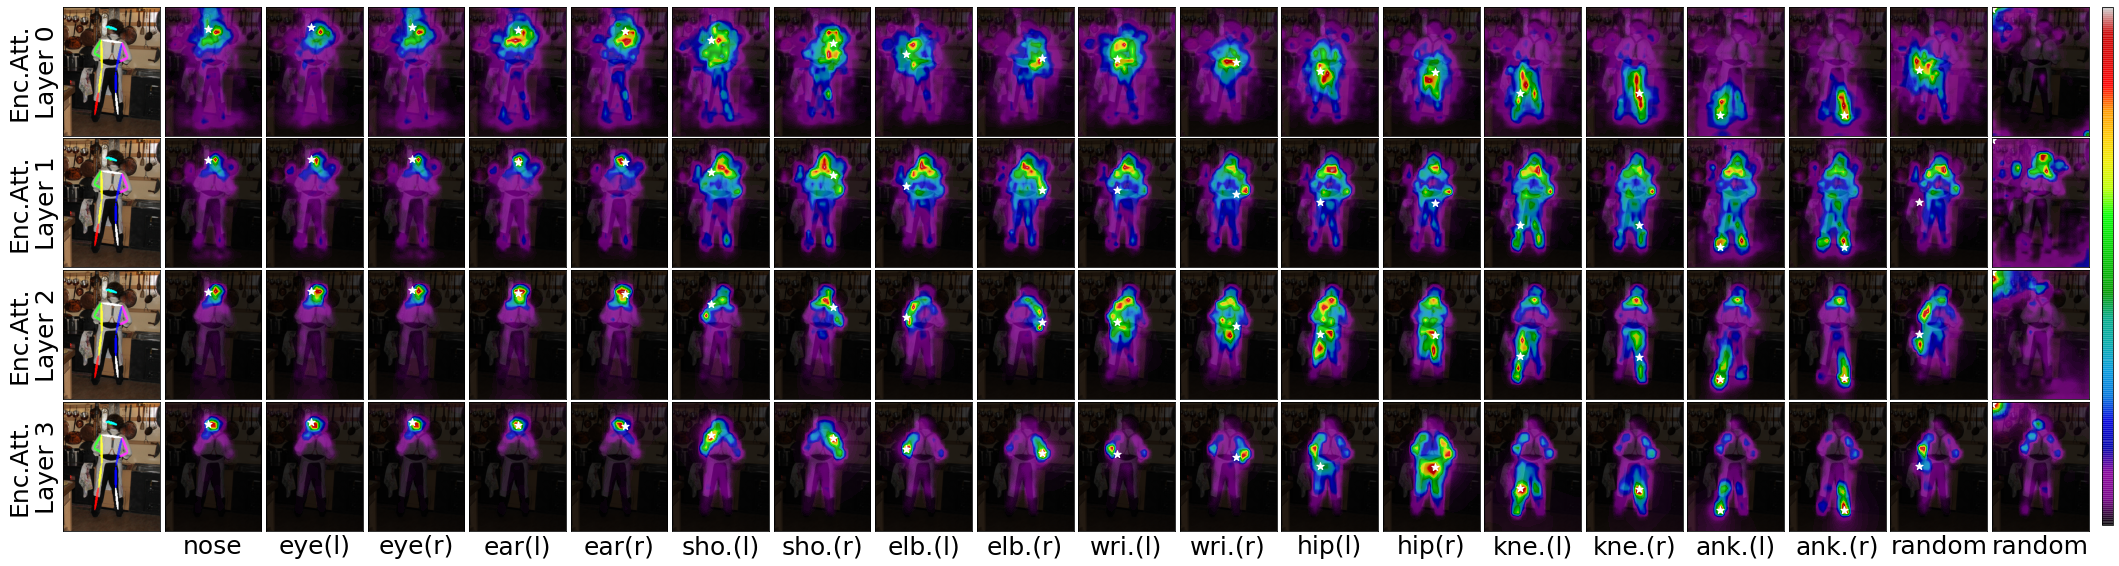

In [3]:
from visualize import inspect_atten_map_by_locations

inspect_atten_map_by_locations(img, model, query_locations, model_name="transposer", mode='dependency', save_img=True, threshold=0.0)
